<a href="https://colab.research.google.com/github/kbansal17/land_cover_land_use_lake_using_svm/blob/main/svm_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()
tif_files = list(uploaded.keys())
print("Uploaded files:", tif_files)

Saving Landsat_1990_Madurantakam.tif to Landsat_1990_Madurantakam.tif
Saving Landsat_2000_Madurantakam.tif to Landsat_2000_Madurantakam.tif
Saving Landsat_2010_Madurantakam.tif to Landsat_2010_Madurantakam.tif
Saving Sentinel2_2020_Madurantakam.tif to Sentinel2_2020_Madurantakam.tif
Uploaded files: ['Landsat_1990_Madurantakam.tif', 'Landsat_2000_Madurantakam.tif', 'Landsat_2010_Madurantakam.tif', 'Sentinel2_2020_Madurantakam.tif']



Processing Landsat_1990_Madurantakam.tif...

Classification Report:
              precision    recall  f1-score   support

       Water       0.99      0.25      0.40       485
  Vegetation       0.37      1.00      0.54      1722
       Urban       1.00      0.03      0.06      1508
      Barren       0.98      0.05      0.09      1222

    accuracy                           0.39      4937
   macro avg       0.83      0.33      0.27      4937
weighted avg       0.77      0.39      0.26      4937



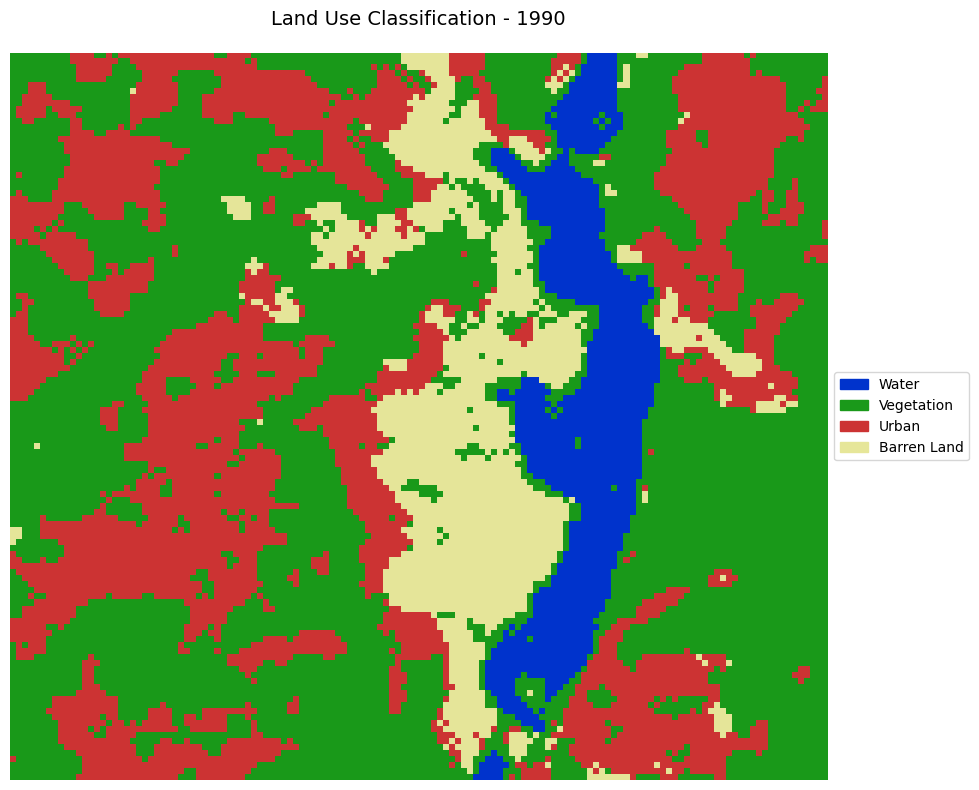


Processing Landsat_2000_Madurantakam.tif...

Classification Report:
              precision    recall  f1-score   support

       Water       0.96      0.80      0.87      1720
  Vegetation       0.49      1.00      0.66      1606
       Urban       1.00      0.01      0.02        81
      Barren       0.73      0.11      0.18      1530

    accuracy                           0.64      4937
   macro avg       0.80      0.48      0.43      4937
weighted avg       0.74      0.64      0.57      4937



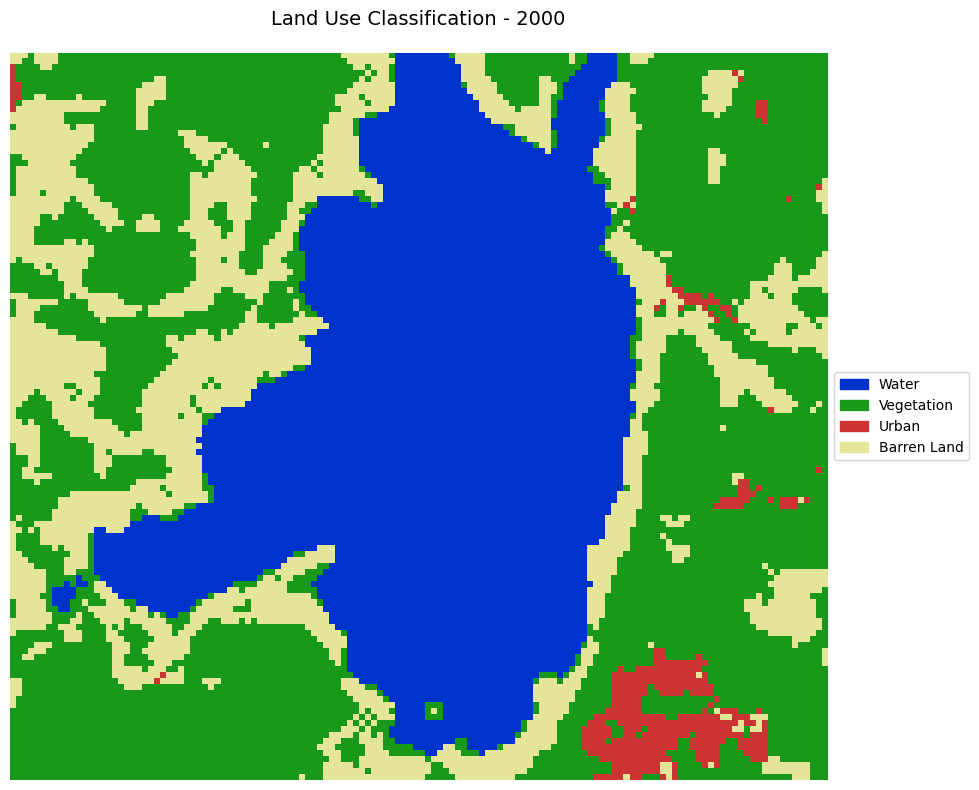


Processing Landsat_2010_Madurantakam.tif...

Classification Report:
              precision    recall  f1-score   support

       Water       0.99      0.56      0.71      1063
  Vegetation       0.00      0.00      0.00       835
       Urban       0.35      1.00      0.52      1176
      Barren       1.00      0.51      0.68      1863

    accuracy                           0.55      4937
   macro avg       0.58      0.52      0.48      4937
weighted avg       0.67      0.55      0.53      4937



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


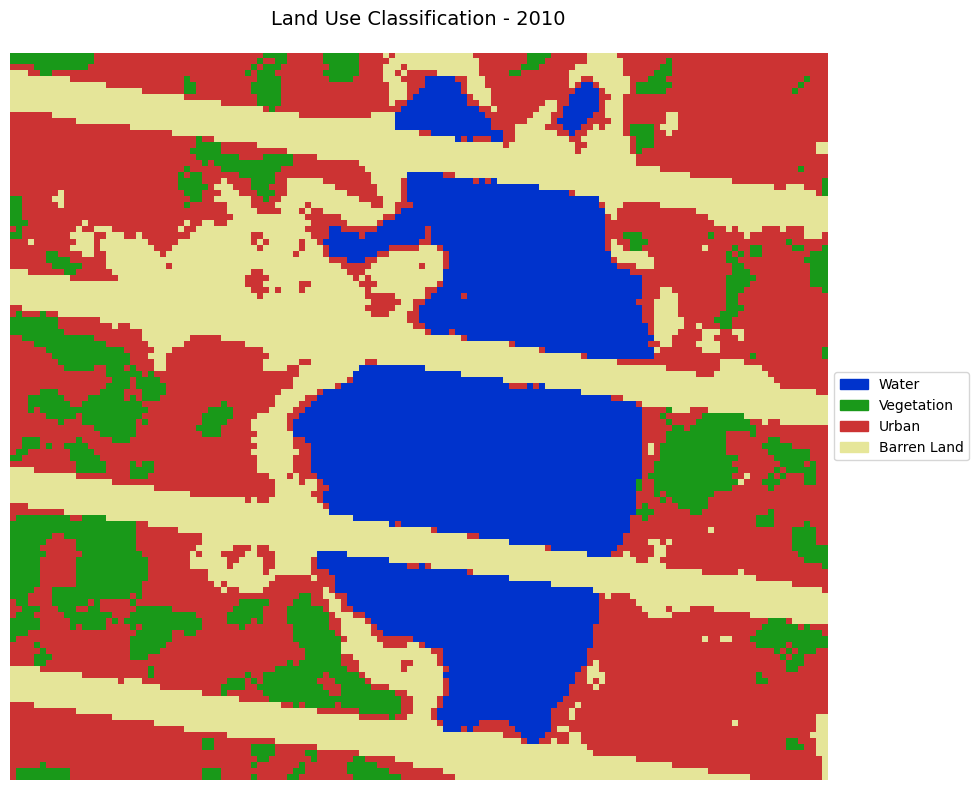


Processing Sentinel2_2020_Madurantakam.tif...

Classification Report:
              precision    recall  f1-score   support

       Water       0.81      1.00      0.89      3968
       Urban       0.50      0.00      0.00       930
      Barren       0.00      0.00      0.00         3

    accuracy                           0.81      4901
   macro avg       0.44      0.33      0.30      4901
weighted avg       0.75      0.81      0.72      4901



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


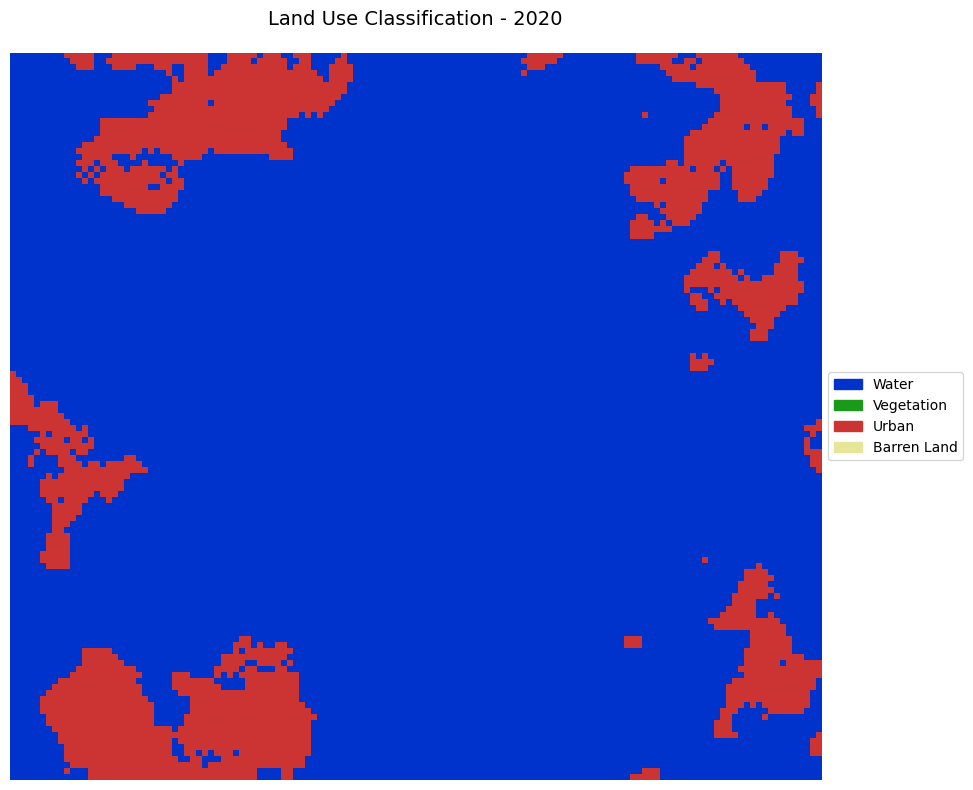

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from skimage.filters import median
from skimage.morphology import disk, binary_closing, binary_opening
import matplotlib.patches as mpatches

def load_image(image_path):
    with rasterio.open(image_path) as dataset:
        bands = dataset.read()
        metadata = dataset.meta
    return bands.astype(np.float32), metadata

def calculate_indices(bands):
    green, red, nir, swir = bands[1], bands[2], bands[3], bands[4]

    # Calculate indices with error handling
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir - red) / (nir + red)
        ndwi = (green - nir) / (green + nir)
        mndwi = (green - swir) / (green + swir)  # Modified NDWI for better water detection
        ndbi = (swir - nir) / (swir + nir)

    # Clean up infinite values
    ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=1.0, neginf=-1.0)
    ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=1.0, neginf=-1.0)
    mndwi = np.nan_to_num(mndwi, nan=0.0, posinf=1.0, neginf=-1.0)
    ndbi = np.nan_to_num(ndbi, nan=0.0, posinf=1.0, neginf=-1.0)

    return ndvi, ndwi, mndwi, ndbi

def enhance_water_detection(ndwi, mndwi, green, nir, swir):
    """Enhanced water detection using multiple indices and band thresholds"""
    water_mask = np.zeros_like(ndwi, dtype=bool)

    # Combine multiple water detection criteria
    water_mask1 = (ndwi > 0.1) & (mndwi > 0.1)  # Using both NDWI and MNDWI
    water_mask2 = (green > nir) & (green > swir)  # Basic spectral water detection
    water_mask3 = (mndwi > 0.0) & (ndwi > 0.0)   # Less strict threshold for historical images

    water_mask = water_mask1 | water_mask2 | water_mask3

    # Apply morphological operations to clean up the water mask
    water_mask = binary_closing(water_mask, disk(2))
    water_mask = binary_opening(water_mask, disk(1))

    return water_mask

def assign_labels(bands, ndvi, ndwi, mndwi, ndbi):
    labels = np.full(ndvi.shape, -1, dtype=np.int32)

    # Enhanced water detection
    water_mask = enhance_water_detection(ndwi, mndwi, bands[1], bands[3], bands[4])
    labels[water_mask] = 0

    # Non-water classification
    non_water = ~water_mask

    # Vegetation (in non-water areas)
    veg_mask = (ndvi > 0.2) & non_water
    labels[veg_mask] = 1

    # Urban/Built-up (in non-water areas)
    urban_mask = (ndbi > 0.0) & (ndvi < 0.2) & non_water & ~veg_mask
    labels[urban_mask] = 2

    # Barren Land (remaining areas)
    labels[labels == -1] = 3

    return labels

def prepare_features(file_path):
    print(f"\nProcessing {file_path}...")
    bands, metadata = load_image(file_path)
    ndvi, ndwi, mndwi, ndbi = calculate_indices(bands)

    # Stack all bands and indices as features
    features = np.stack([
        bands[1].ravel(),  # Green
        bands[2].ravel(),  # Red
        bands[3].ravel(),  # NIR
        bands[4].ravel(),  # SWIR
        ndvi.ravel(),
        ndwi.ravel(),
        mndwi.ravel(),
        ndbi.ravel()
    ], axis=1)

    labels = assign_labels(bands, ndvi, ndwi, mndwi, ndbi)

    return features, labels.ravel(), bands[0].shape

def train_and_classify(features, labels, shape):
    # Remove any invalid values
    valid_mask = ~np.isnan(features).any(axis=1)
    X = features[valid_mask]
    y = labels[valid_mask]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create and train the classifier with adjusted parameters
    classifier = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('svm', SVC(kernel='rbf', C=100.0, gamma='auto', class_weight='balanced', random_state=42))
    ])

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Get the unique labels present in the data
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))

    # Filter target names based on unique labels
    target_names = ['Water', 'Vegetation', 'Urban', 'Barren']  # Original target names
    filtered_target_names = [target_names[i] for i in unique_labels]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=filtered_target_names)) # Use filtered target names

    # Predict for the entire image
    predicted_labels = classifier.predict(features)
    return predicted_labels.reshape(shape)

def plot_classification(classified_image, title):
    # Apply median filter to smooth the classification
    smoothed = median(classified_image, disk(2))

    # Define colors for each class (adjusted for better visibility)
    colors = {
        0: [0, 0.2, 0.8],    # Water (Darker Blue)
        1: [0.1, 0.6, 0.1],  # Vegetation (Darker Green)
        2: [0.8, 0.2, 0.2],  # Urban (Darker Red)
        3: [0.9, 0.9, 0.6]   # Barren Land (Beige)
    }

    # Create RGB image
    rgb_image = np.zeros((*smoothed.shape, 3))
    for label, color in colors.items():
        rgb_image[smoothed == label] = color

    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_image)
    plt.title(f'Land Use Classification - {title}', fontsize=14, pad=20)

    # Add legend
    legend_patches = [
        mpatches.Patch(color=colors[0], label='Water'),
        mpatches.Patch(color=colors[1], label='Vegetation'),
        mpatches.Patch(color=colors[2], label='Urban'),
        mpatches.Patch(color=colors[3], label='Barren Land')
    ]
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_image(file_path):
    features, labels, shape = prepare_features(file_path)
    classified = train_and_classify(features, labels, shape)
    year = file_path.split('_')[1]
    plot_classification(classified, year)

# Process all images
files = [
    'Landsat_1990_Madurantakam.tif',
    'Landsat_2000_Madurantakam.tif',
    'Landsat_2010_Madurantakam.tif',
    'Sentinel2_2020_Madurantakam.tif'
]

for file_path in files:
    process_image(file_path)